# Decision tree by strokes

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [2]:
df = pd.read_parquet('CLEANED_SWIM_DATA.parquet')
df.loc[:,'isHS'] = df.loc[:,'Division'] == 'HS'
df.head()

,Event,Conf_Rank,Time,Name,School,Standard,Date,Gender,Division,Season,...,Time_Adj,Time_Sec,Div_Rank,NCAA_Rank,ID,Power_Tot,Power,Record,Points,isHS
0,50 Freestyle SCY Male,-1,21.22,Ben Beldner,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.220000,21.22,-1,-1,394588,22.71,20.52,17.63,573.483330,True
1,50 Freestyle SCY Male,-1,20.87,Justin Meyn,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:20.870000,20.87,-1,-1,471360,10.06,20.80,17.63,602.822689,True
2,50 Freestyle SCY Male,-1,21.31,Joshua Franco,New Jersey Institute of Technology,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.310000,21.31,-1,-1,395308,12.40,22.05,17.63,566.247878,True
3,50 Freestyle SCY Male,-1,21.05,Gabe Laracuente,UMBC,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.050000,21.05,-1,-1,404642,13.77,23.93,17.63,587.490213,True
4,50 Freestyle SCY Male,-1,21.70,Ryan Board,Binghamton,NA,2000-01-01,M,HS,00_01,...,0 days 00:00:21.700000,21.70,-1,-1,422211,18.21,28.82,17.63,536.262879,True


In [3]:
df['School'] = df['School'].astype('category')

## Freestyle

In [4]:
# Step 1: Group by swimmer ID and find their top 4 events by Points
top_4_per_swimmer = (
    df.groupby('ID')
    .apply(lambda group: group.nlargest(4, 'Points'))
    .reset_index(drop=True)
)

# Step 2: Identify swimmers with at least 2 freestyle events in their top 4
freestyle_ids = (
    top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains('freestyle', case=False)]
    .groupby('ID')
    .size()  # Count the number of freestyle events in the top 4
    .loc[lambda x: x >= 2]  # Keep swimmers with at least 2 freestyle events
    .index
)

# Step 3: Filter the original dataset to only include these swimmers
freestyle_filtered_df = df[df['ID'].isin(freestyle_ids)]

# Step 4: For these swimmers, keep only their freestyle events
freestyle_only = freestyle_filtered_df[
    freestyle_filtered_df['Event'].str.contains('freestyle', case=False)
]

# Step 5: Create the pivot table, averaging the top 5 Points
college_freestyler = freestyle_only.pivot_table(
    values='Points', 
    index='ID', 
    columns='isHS', 
    aggfunc='mean'
)

# Display the final pivot table
college_freestyler

/tmp/ipykernel_1718720/884771536.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(4, 'Points'))


isHS,False,True
ID,,
2870,504.241363,346.525958
3480,427.144723,584.847697
7361,480.005872,629.240396
31849,499.981747,598.562896
55500,481.182479,616.667631
...,...,...
2961793,542.029515,206.839532
3008853,471.848461,224.746739
3017695,546.009002,172.140176


In [5]:
college_freestyler['Difference'] = college_freestyler[False] - college_freestyler[True]
college_freestyler['Difference'] = college_freestyler['Difference'].replace([float('inf'), -float('inf')], float('nan'))
college_freestyler = college_freestyler.dropna(subset=['Difference'])
college_freestyler = college_freestyler.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
college_freestyler

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
2870,504.241363,346.525958,157.715405
3480,427.144723,584.847697,-157.702974
7361,480.005872,629.240396,-149.234524
31849,499.981747,598.562896,-98.581149
55500,481.182479,616.667631,-135.485152
...,...,...,...
2961793,542.029515,206.839532,335.189983
3008853,471.848461,224.746739,247.101722
3017695,546.009002,172.140176,373.868826


In [6]:
freestyle = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  college_freestyler, 
                  on=['ID'], 
                  how='left')
freestyle = freestyle.dropna()
freestyle['Rating'] = pd.cut(freestyle['Difference'], [-1000, 5, 1000], labels = ['bad', 'good'])
freestyle['Rating'].value_counts()

Rating
good    105765
bad     103145
Name: count, dtype: int64

In [7]:
X = freestyle[['Gender', 'Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Gender_F,Gender_M,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
0,0,1,1,0,0,0,1,0,0,0,0,0
1,0,1,1,0,0,0,1,0,0,0,0,0
2,0,1,1,0,0,0,1,0,0,0,0,0
3,0,1,1,0,0,0,1,0,0,0,0,0
5,0,1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354318,1,0,0,0,0,1,0,0,0,0,0,1
354319,1,0,0,0,0,1,0,0,0,0,0,1
354320,1,0,0,0,0,1,0,0,0,0,0,1
354321,1,0,0,0,0,1,0,0,0,0,0,1


In [8]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [9]:
y = freestyle['Rating']

### Decision Tree with CV

In [10]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [11]:
dtreeCV.best_params_

{'max_depth': 2}

In [12]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5706715810636159


In [13]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.573449,0.507046
1,2,0.576716,0.524657
2,3,0.583589,0.483476
3,4,0.587980,0.476641
4,5,0.588416,0.476641
5,6,0.588416,0.476641
6,7,0.588416,0.476641
7,8,0.588416,0.476641
8,9,0.588416,0.476641
9,10,0.588416,0.476641


<Axes: xlabel='depth'>

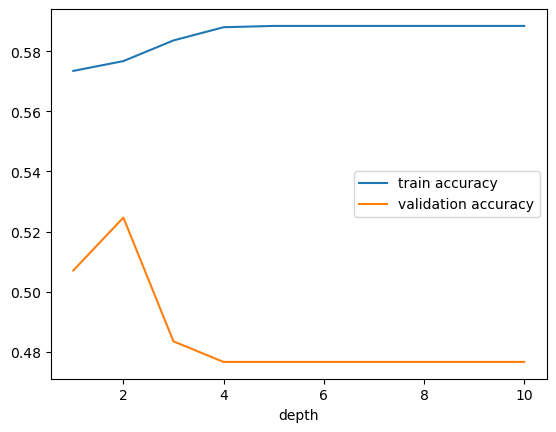

In [14]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [15]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,0.914999
1,Gender_M,0.000000
2,Division_I,0.037927
3,Division_II,0.000000
4,Division_III,0.047074
5,Season_19_20,0.000000
6,Season_20_21,0.000000
7,Season_21_22,0.000000
8,Season_22_23,0.000000
9,Season_23_24,0.000000


### Decision Tree at fixed depth

In [16]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [17]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5715427696137092


In [18]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Gender_F <= 0.5
|     |----- Division_I <= 0.5
|     |     |----- Division_III <= 0.5
|     |     |     |----- Season_19_20 <= 0.5
|     |     |     |     |----- Division_II <= 0.5
|     |     |     |     |     |----- class: good
|     |     |     |     |----- Division_II >  0.5
|     |     |     |     |     |----- Season_23_24 <= 0.5
|     |     |     |     |     |     |----- Season_22_23 <= 0.5
|     |     |     |     |     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Season_22_23 >  0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |----- Season_23_24 >  0.5
|     |     |     |     |     |     |----- class: good
|     |     |     |----- Season_19_20 >  0.5
|     |     |     |     |----- class: go

In [19]:
freestyle_importances = dtree1.feature_importances_
df_freestyle_importances = pd.DataFrame()
df_freestyle_importances['Features'] = X_ohe.columns
df_freestyle_importances['importance'] = freestyle_importances
df_freestyle_importances.sort_values('importance', ascending=False)

,Features,importance
0,Gender_F,0.847195
2,Division_I,0.053306
4,Division_III,0.052691
5,Season_19_20,0.027023
9,Season_23_24,0.013576
8,Season_22_23,0.003378
3,Division_II,0.001893
7,Season_21_22,0.000744
6,Season_20_21,0.000194
1,Gender_M,0.000000


## Backstroke

In [20]:
# Step 1: Group by swimmer ID and find their top 4 events by Points
top_4_per_swimmer = (
    df.groupby('ID')
    .apply(lambda group: group.nlargest(4, 'Points'))
    .reset_index(drop=True)
)

# Step 2: Identify swimmers with at least 2 freestyle events in their top 4
backstroke_ids = (
    top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains('backstroke', case=False)]
    .groupby('ID')
    .size()  # Count the number of freestyle events in the top 4
    .loc[lambda x: x >= 2]  # Keep swimmers with at least 2 freestyle events
    .index
)

# Step 3: Filter the original dataset to only include these swimmers
backstroke_filtered_df = df[df['ID'].isin(backstroke_ids)]

# Step 4: For these swimmers, keep only their freestyle events
backstroke_only = backstroke_filtered_df[
    backstroke_filtered_df['Event'].str.contains('backstroke', case=False)
]

# Step 5: Create the pivot table, averaging the top 5 Points
college_backstroker = backstroke_only.pivot_table(
    values='Points', 
    index='ID', 
    columns='isHS', 
    aggfunc='mean'
)

# Display the final pivot table
college_backstroker

/tmp/ipykernel_1718720/3462844664.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(4, 'Points'))


isHS,False,True
ID,,
76046,480.787974,409.599669
98286,NaN,487.360744
180883,448.126881,609.669374
182847,556.059482,645.956225
187695,386.915652,NaN
...,...,...
2692774,456.134473,494.905434
2721776,489.747648,472.052285
2742149,225.565902,537.069322


In [21]:
college_backstroker['Difference'] = college_backstroker[False] - college_backstroker[True]
college_backstroker['Difference'] = college_backstroker['Difference'].replace([float('inf'), -float('inf')], float('nan'))
college_backstroker = college_backstroker.dropna(subset=['Difference'])
college_backstroker = college_backstroker.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
college_backstroker

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
76046,480.787974,409.599669,71.188305
180883,448.126881,609.669374,-161.542493
182847,556.059482,645.956225,-89.896742
197153,528.893168,681.178676,-152.285507
201001,647.786144,664.082684,-16.296540
...,...,...,...
2679850,524.385958,684.848886,-160.462928
2692774,456.134473,494.905434,-38.770961
2721776,489.747648,472.052285,17.695363


In [22]:
backstroke = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  college_backstroker, 
                  on=['ID'], 
                  how='left')
backstroke = backstroke.dropna()

In [23]:
backstroke['Rating'] = pd.cut(backstroke['Difference'], [-1000, -70, 1000], labels = ['bad', 'good'])
backstroke['Rating'].value_counts()

Rating
bad     22335
good    22103
Name: count, dtype: int64

In [24]:
X = backstroke[['Gender', 'Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [25]:
y = backstroke['Rating']

### Decision Tree with CV

In [26]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

/opt/miniforge3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [27]:
dtreeCV.best_params_

{'max_depth': 1}

In [28]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.8718664206309915


In [29]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.871866,0.871864
1,2,0.872457,0.833155
2,3,0.874780,0.741704
3,4,0.878651,0.583932
4,5,0.879844,0.534197
5,6,0.879967,0.528526
6,7,0.879967,0.528526
7,8,0.879967,0.528526
8,9,0.879967,0.528526
9,10,0.879967,0.528526


<Axes: xlabel='depth'>

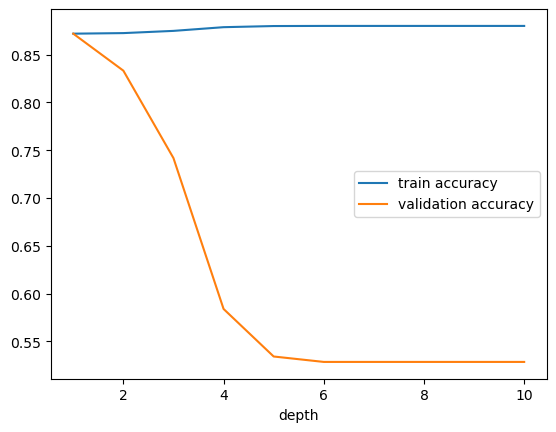

In [30]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [31]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,0.0
1,Gender_M,1.0
2,Division_I,0.0
3,Division_II,0.0
4,Division_III,0.0
5,Season_19_20,0.0
6,Season_20_21,0.0
7,Season_21_22,0.0
8,Season_22_23,0.0
9,Season_23_24,0.0


### Decision Tree at Fixed Depth

In [32]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [33]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.8718664206309915


In [34]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Gender_F <= 0.5
|     |----- Division_I <= 0.5
|     |     |----- Season_22_23 <= 0.5
|     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |----- Season_19_20 <= 0.5
|     |     |     |     |     |     |----- Division_II <= 0.5
|     |     |     |     |     |     |     |----- Division_III <= 0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |     |----- Division_III >  0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Division_II >  0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |----- Season_19_20 >  0.5
|     |     |     |     |     |     |----- Division_II <= 0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Division_II >  0.5
|     |     |     |     |     |     |     |----- class:

In [35]:
backstroke_importances = dtree1.feature_importances_
df_backstroke_importances = pd.DataFrame()
df_backstroke_importances['Features'] = X_ohe.columns
df_backstroke_importances['importance'] = backstroke_importances
df_backstroke_importances.sort_values('importance', ascending=False)

,Features,importance
0,Gender_F,0.983055
4,Division_III,0.008322
3,Division_II,0.006180
2,Division_I,0.001049
5,Season_19_20,0.000495
9,Season_23_24,0.000400
6,Season_20_21,0.000325
8,Season_22_23,0.000141
7,Season_21_22,0.000032
1,Gender_M,0.000000


## Breastroke

In [36]:
# Step 1: Group by swimmer ID and find their top 4 events by Points
top_4_per_swimmer = (
    df.groupby('ID')
    .apply(lambda group: group.nlargest(4, 'Points'))
    .reset_index(drop=True)
)

# Step 2: Identify swimmers with at least 2 freestyle events in their top 4
breast_ids = (
    top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains('breaststroke', case=False)]
    .groupby('ID')
    .size()  # Count the number of freestyle events in the top 4
    .loc[lambda x: x >= 2]  # Keep swimmers with at least 2 freestyle events
    .index
)

# Step 3: Filter the original dataset to only include these swimmers
breast_filtered_df = df[df['ID'].isin(breast_ids)]

# Step 4: For these swimmers, keep only their freestyle events
breast_only = breast_filtered_df[
    breast_filtered_df['Event'].str.contains('breaststroke', case=False)
]

# Step 5: Create the pivot table, averaging the top 5 Points
college_breast = breast_only.pivot_table(
    values='Points', 
    index='ID', 
    columns='isHS', 
    aggfunc='mean'
)

# Display the final pivot table
college_breast

/tmp/ipykernel_1718720/432029209.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(4, 'Points'))


isHS,False,True
ID,,
19185,NaN,969.298323
57813,497.069940,NaN
106626,411.789353,638.677132
114236,594.401834,NaN
117612,666.279368,380.333916
...,...,...
2685500,635.838441,617.865718
2821522,465.991307,599.108535
2886611,713.588714,580.573480


In [37]:
college_breast['Difference'] = college_breast[False] - college_breast[True]
college_breast['Difference'] = college_breast['Difference'].replace([float('inf'), -float('inf')], float('nan'))
college_breast = college_breast.dropna(subset=['Difference'])
college_breast = college_breast.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
college_breast

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
106626,411.789353,638.677132,-226.887780
117612,666.279368,380.333916,285.945452
148222,560.928846,602.253823,-41.324977
148340,704.560017,637.067047,67.492970
152655,678.577985,477.650729,200.927255
...,...,...,...
2685500,635.838441,617.865718,17.972723
2821522,465.991307,599.108535,-133.117228
2886611,713.588714,580.573480,133.015234


In [38]:
breaststroke = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  college_breast, 
                  on=['ID'], 
                  how='left')
breaststroke = breaststroke.dropna()
breaststroke['Rating'] = pd.cut(breaststroke['Difference'], [-1000, 5, 1000], labels = ['bad', 'good'])
breaststroke['Rating'].value_counts()

Rating
good    29980
bad     20554
Name: count, dtype: int64

In [39]:
X = breaststroke[['Gender', 'Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Gender_F,Gender_M,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
4,0,1,1,0,0,0,1,0,0,0,0,0
14,0,1,1,0,0,0,1,0,0,0,0,0
20,0,1,1,0,0,0,1,0,0,0,0,0
22,0,1,1,0,0,0,1,0,0,0,0,0
23,0,1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354290,1,0,0,0,0,1,0,0,0,0,0,1
354292,1,0,0,0,0,1,0,0,0,0,0,1
354298,1,0,0,0,0,1,0,0,0,0,0,1
354311,1,0,0,0,0,1,0,0,0,0,0,1


In [40]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [41]:
y = breaststroke['Rating']

### Decision Tree with CV

In [42]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

/opt/miniforge3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [43]:
dtreeCV.best_params_

{'max_depth': 1}

In [44]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5953417501088376


In [45]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.603114,0.555940
1,2,0.607185,0.507834
2,3,0.614903,0.529285
3,4,0.618504,0.513019
4,5,0.620414,0.495407
5,6,0.620824,0.495407
6,7,0.621324,0.495407
7,8,0.621324,0.495407
8,9,0.621324,0.495407
9,10,0.621324,0.495407


<Axes: xlabel='depth'>

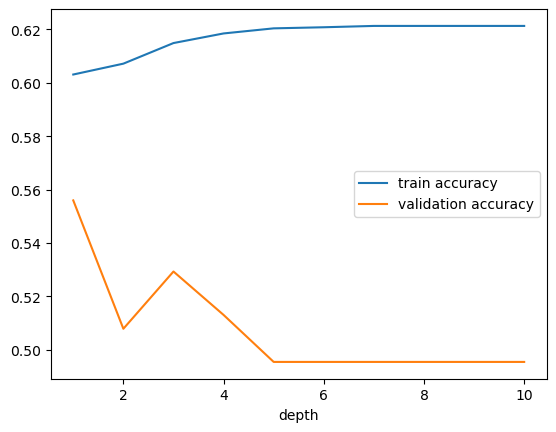

In [46]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [47]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,0.0
1,Gender_M,1.0
2,Division_I,0.0
3,Division_II,0.0
4,Division_III,0.0
5,Season_19_20,0.0
6,Season_20_21,0.0
7,Season_21_22,0.0
8,Season_22_23,0.0
9,Season_23_24,0.0


### Decision Tree at fixed depth

In [48]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [49]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.6074721969367158


In [50]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Gender_M <= 0.5
|     |----- Division_II <= 0.5
|     |     |----- Division_III <= 0.5
|     |     |     |----- Division_I <= 0.5
|     |     |     |     |----- class: bad
|     |     |     |----- Division_I >  0.5
|     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |     |     |----- Season_19_20 <= 0.5
|     |     |     |     |     |     |     |----- Season_22_23 <= 0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |     |----- Season_22_23 >  0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Season_19_20 >  0.5
|     |     |     |     |     |     |     |----- class: bad
|     |     |     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |     |     |----- class: bad
|     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |----- class: bad
| 

In [51]:
breaststroke_importances = dtree1.feature_importances_
df_breaststroke_importances = pd.DataFrame()
df_breaststroke_importances['Features'] = X_ohe.columns
df_breaststroke_importances['importance'] = breaststroke_importances
df_breaststroke_importances.sort_values('importance', ascending=False)

,Features,importance
1,Gender_M,0.940760
2,Division_I,0.016791
4,Division_III,0.012384
3,Division_II,0.010875
6,Season_20_21,0.009162
8,Season_22_23,0.003631
9,Season_23_24,0.002885
5,Season_19_20,0.002265
7,Season_21_22,0.001247
0,Gender_F,0.000000


## Butterfly

In [52]:
# Step 1: Group by swimmer ID and find their top 4 events by Points
top_4_per_swimmer = (
    df.groupby('ID')
    .apply(lambda group: group.nlargest(4, 'Points'))
    .reset_index(drop=True)
)

# Step 2: Identify swimmers with at least 2 freestyle events in their top 4
butterfly_ids = (
    top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains('butterfly', case=False)]
    .groupby('ID')
    .size()  # Count the number of freestyle events in the top 4
    .loc[lambda x: x >= 2]  # Keep swimmers with at least 2 freestyle events
    .index
)

# Step 3: Filter the original dataset to only include these swimmers
butterfly_filtered_df = df[df['ID'].isin(butterfly_ids)]

# Step 4: For these swimmers, keep only their freestyle events
butterfly_only = butterfly_filtered_df[
    butterfly_filtered_df['Event'].str.contains('butterfly', case=False)
]

# Step 5: Create the pivot table, averaging the top 5 Points
college_butterflyer = butterfly_only.pivot_table(
    values='Points', 
    index='ID', 
    columns='isHS', 
    aggfunc='mean'
)

# Display the final pivot table
college_butterflyer

/tmp/ipykernel_1718720/1836093545.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(4, 'Points'))


isHS,False,True
ID,,
86833,436.741272,377.950547
88551,372.530564,NaN
93211,388.055648,618.327907
104506,590.159875,NaN
121324,452.028819,611.166766
...,...,...
2537757,629.867516,NaN
2694511,572.272647,352.300642
2749205,301.526194,769.626866


In [53]:
college_butterflyer['Difference'] = college_butterflyer[False] - college_butterflyer[True]
college_butterflyer['Difference'] = college_butterflyer['Difference'].replace([float('inf'), -float('inf')], float('nan'))
college_butterflyer = college_butterflyer.dropna(subset=['Difference'])
college_butterflyer = college_butterflyer.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
college_butterflyer

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
86833,436.741272,377.950547,58.790725
93211,388.055648,618.327907,-230.272259
121324,452.028819,611.166766,-159.137946
147862,600.898683,399.884942,201.013742
148016,485.173423,453.941254,31.232169
...,...,...,...
2364483,605.281957,213.864281,391.417676
2694511,572.272647,352.300642,219.972005
2749205,301.526194,769.626866,-468.100672


In [54]:
butterfly = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  college_butterflyer, 
                  on=['ID'], 
                  how='left')
butterfly = butterfly.dropna()
butterfly['Rating'] = pd.cut(butterfly['Difference'], [-1000, 5, 1000], labels = ['bad', 'good'])
butterfly['Rating'].value_counts()

Rating
good    24756
bad     22121
Name: count, dtype: int64

In [55]:
X = butterfly[['Gender', 'Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Gender_F,Gender_M,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
10,0,1,1,0,0,0,1,0,0,0,0,0
15,0,1,1,0,0,0,1,0,0,0,0,0
17,0,1,1,0,0,0,1,0,0,0,0,0
19,0,1,1,0,0,0,1,0,0,0,0,0
25,0,1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
353826,1,0,0,0,0,1,0,0,0,0,0,1
353832,1,0,0,0,0,1,0,0,0,0,0,1
353857,1,0,0,0,0,1,0,0,0,0,0,1
353868,1,0,0,0,0,1,0,0,0,0,0,1


In [56]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [57]:
y = butterfly['Rating']

### Decision Tree with CV

In [58]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

/opt/miniforge3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [59]:
dtreeCV.best_params_

{'max_depth': 2}

In [60]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.655289374320029


In [61]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.657193,0.486308
1,2,0.665561,0.570745
2,3,0.672542,0.486308
3,4,0.676072,0.470671
4,5,0.676072,0.470671
5,6,0.676072,0.470671
6,7,0.676072,0.470671
7,8,0.676072,0.470671
8,9,0.676072,0.470671
9,10,0.676072,0.470671


<Axes: xlabel='depth'>

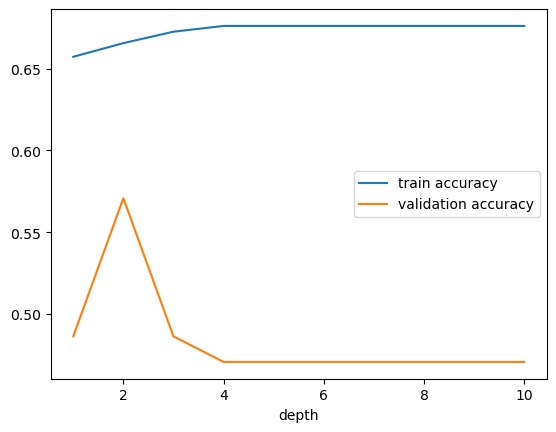

In [62]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [63]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,0.000000
1,Gender_M,0.963130
2,Division_I,0.000000
3,Division_II,0.018528
4,Division_III,0.018342
5,Season_19_20,0.000000
6,Season_20_21,0.000000
7,Season_21_22,0.000000
8,Season_22_23,0.000000
9,Season_23_24,0.000000


### Decision Tree at fixed depth

In [64]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [65]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.655289374320029


In [66]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Gender_F <= 0.5
|     |----- Division_II <= 0.5
|     |     |----- Season_19_20 <= 0.5
|     |     |     |----- Season_23_24 <= 0.5
|     |     |     |     |----- Season_22_23 <= 0.5
|     |     |     |     |     |----- Division_III <= 0.5
|     |     |     |     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Season_20_21 >  0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |----- Division_III >  0.5
|     |     |     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |     |     |----- c

In [67]:
butterfly_importances = dtree1.feature_importances_
df_butterfly_importances = pd.DataFrame()
df_butterfly_importances['Features'] = X_ohe.columns
df_butterfly_importances['importance'] = butterfly_importances
df_butterfly_importances.sort_values('importance', ascending=False)

,Features,importance
0,Gender_F,0.943742
3,Division_II,0.024408
4,Division_III,0.018887
5,Season_19_20,0.005873
9,Season_23_24,0.003022
8,Season_22_23,0.002627
6,Season_20_21,0.000893
2,Division_I,0.000353
7,Season_21_22,0.000196
1,Gender_M,0.000000


## IM

In [68]:
# Step 1: Group by swimmer ID and find their top 4 events by Points
top_4_per_swimmer = (
    df.groupby('ID')
    .apply(lambda group: group.nlargest(4, 'Points'))
    .reset_index(drop=True)
)

# Step 2: Identify swimmers with at least 2 freestyle events in their top 4
im_ids = (
    top_4_per_swimmer[top_4_per_swimmer['Event'].str.contains('medley', case=False)]
    .groupby('ID')
    .size()  # Count the number of freestyle events in the top 4
    .loc[lambda x: x >= 2]  # Keep swimmers with at least 2 freestyle events
    .index
)

# Step 3: Filter the original dataset to only include these swimmers
im_filtered_df = df[df['ID'].isin(im_ids)]

# Step 4: For these swimmers, keep only their freestyle events
im_only = im_filtered_df[
    im_filtered_df['Event'].str.contains('medley', case=False)
]

# Step 5: Create the pivot table, averaging the top 5 Points
college_im = im_only.pivot_table(
    values='Points', 
    index='ID', 
    columns='isHS', 
    aggfunc='mean'
)

# Display the final pivot table
college_im

/tmp/ipykernel_1718720/1822334393.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(4, 'Points'))


isHS,False,True
ID,,
7361,NaN,710.065738
113456,452.160939,498.877205
114434,477.704212,543.496277
121324,497.953849,446.727485
148125,511.844714,495.011233
...,...,...
2692553,420.607499,359.499423
2692774,539.120381,468.731589
2809413,777.604034,610.522999


In [69]:
college_im['Difference'] = college_im[False] - college_im[True]
college_im['Difference'] = college_im['Difference'].replace([float('inf'), -float('inf')], float('nan'))
college_im = college_im.dropna(subset=['Difference'])
college_im = college_im.rename(columns={True: 'Best_HS_Points', False: 'Best_College_Points'})
college_im

isHS,Best_College_Points,Best_HS_Points,Difference
ID,,,
113456,452.160939,498.877205,-46.716265
114434,477.704212,543.496277,-65.792064
121324,497.953849,446.727485,51.226364
148125,511.844714,495.011233,16.833481
169325,609.909954,610.871090,-0.961135
...,...,...,...
2666987,660.919616,455.896221,205.023395
2692553,420.607499,359.499423,61.108076
2692774,539.120381,468.731589,70.388792


In [70]:
im = pd.merge(df[['ID', 'School', 'Standard', 'Gender', 'Division', 'Season']], 
                  college_im, 
                  on=['ID'], 
                  how='left')
im = im.dropna()
im['Rating'] = pd.cut(im['Difference'], [-1000, 20, 1000], labels = ['bad', 'good'])
im['Rating'].value_counts()

Rating
good    23115
bad     17496
Name: count, dtype: int64

In [71]:
X = im[['Gender', 'Division', 'Season']]
# one hot encoding
X_ohe = pd.get_dummies(X).astype('int')
X_ohe

,Gender_F,Gender_M,Division_HS,Division_I,Division_II,Division_III,Season_00_01,Season_19_20,Season_20_21,Season_21_22,Season_22_23,Season_23_24
8,0,1,1,0,0,0,1,0,0,0,0,0
15,0,1,1,0,0,0,1,0,0,0,0,0
20,0,1,1,0,0,0,1,0,0,0,0,0
28,0,1,1,0,0,0,1,0,0,0,0,0
38,0,1,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
354217,1,0,0,0,0,1,0,0,0,0,0,1
354219,1,0,0,0,0,1,0,0,0,0,0,1
354225,1,0,0,0,0,1,0,0,0,0,0,1
354227,1,0,0,0,0,1,0,0,0,0,0,1


In [72]:
X_ohe = X_ohe.drop(['Division_HS', 'Season_00_01'], axis = 1)

In [73]:
y = im['Rating']

### Decision Tree with CV

In [74]:
dtree = DecisionTreeClassifier()
parameters = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
dtreeCV = GridSearchCV(dtree, 
                       param_grid = parameters, 
                       return_train_score = True,
                       n_jobs = -1)
dtreeCV.fit(X_ohe, y)

/opt/miniforge3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [75]:
dtreeCV.best_params_

{'max_depth': 1}

In [76]:
accuracy = dtreeCV.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5831671222082687


In [77]:
results = pd.DataFrame()
results['depth'] = parameters['max_depth']
results['train accuracy'] = dtreeCV.cv_results_['mean_train_score']
results['validation accuracy'] = dtreeCV.cv_results_['mean_test_score']
results

,depth,train accuracy,validation accuracy
0,1,0.586516,0.555785
1,2,0.594993,0.543965
2,3,0.601703,0.496982
3,4,0.607859,0.474450
4,5,0.609478,0.476445
5,6,0.610912,0.476445
6,7,0.611232,0.476445
7,8,0.611232,0.476445
8,9,0.611232,0.476445
9,10,0.611232,0.476445


<Axes: xlabel='depth'>

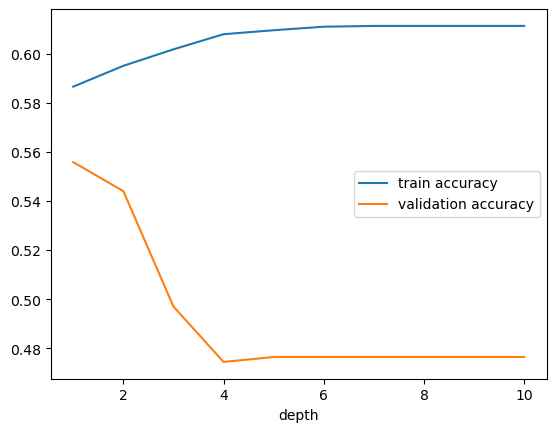

In [78]:
results.plot.line(x='depth', y=['train accuracy', 'validation accuracy'])

In [79]:
dtree_best = dtreeCV.best_estimator_
importances = dtree_best.feature_importances_
df_importances = pd.DataFrame()
df_importances['features'] = X_ohe.columns
df_importances['importances'] = importances
df_importances

,features,importances
0,Gender_F,1.0
1,Gender_M,0.0
2,Division_I,0.0
3,Division_II,0.0
4,Division_III,0.0
5,Season_19_20,0.0
6,Season_20_21,0.0
7,Season_21_22,0.0
8,Season_22_23,0.0
9,Season_23_24,0.0


### Decision Tree at fixed depth

In [80]:
dtree1 = DecisionTreeClassifier(max_depth=10)
dtree1.fit(X_ohe, y)

DecisionTreeClassifier(max_depth=10)

In [81]:
accuracy = dtree1.score(X_ohe, y)
print('Accuracy: ', accuracy)

Accuracy:  0.5960946541577405


In [82]:
dtree_string = export_text(dtree1, feature_names=list(X_ohe.columns), decimals=1, spacing=5)
print(dtree_string)

|----- Gender_F <= 0.5
|     |----- Season_23_24 <= 0.5
|     |     |----- Season_19_20 <= 0.5
|     |     |     |----- Season_20_21 <= 0.5
|     |     |     |     |----- Season_22_23 <= 0.5
|     |     |     |     |     |----- Season_21_22 <= 0.5
|     |     |     |     |     |     |----- class: good
|     |     |     |     |     |----- Season_21_22 >  0.5
|     |     |     |     |     |     |----- Division_III <= 0.5
|     |     |     |     |     |     |     |----- Division_I <= 0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |     |----- Division_I >  0.5
|     |     |     |     |     |     |     |     |----- class: good
|     |     |     |     |     |     |----- Division_III >  0.5
|     |     |     |     |     |     |     |----- class: good
|     |     |     |     |----- Season_22_23 >  0.5
|     |     |     |     |     |----- Division_III <= 0.5
|     |     |     |     |     |     |----- Division_II <= 0.5
|     |     |  

In [83]:
im_importances = dtree1.feature_importances_
df_im_importances = pd.DataFrame()
df_im_importances['Features'] = X_ohe.columns
df_im_importances['importance'] = im_importances
df_im_importances.sort_values('importance', ascending=False)

,Features,importance
0,Gender_F,0.868469
3,Division_II,0.030055
5,Season_19_20,0.029488
2,Division_I,0.024088
9,Season_23_24,0.020274
6,Season_20_21,0.014773
7,Season_21_22,0.006880
8,Season_22_23,0.003141
4,Division_III,0.002833
1,Gender_M,0.000000


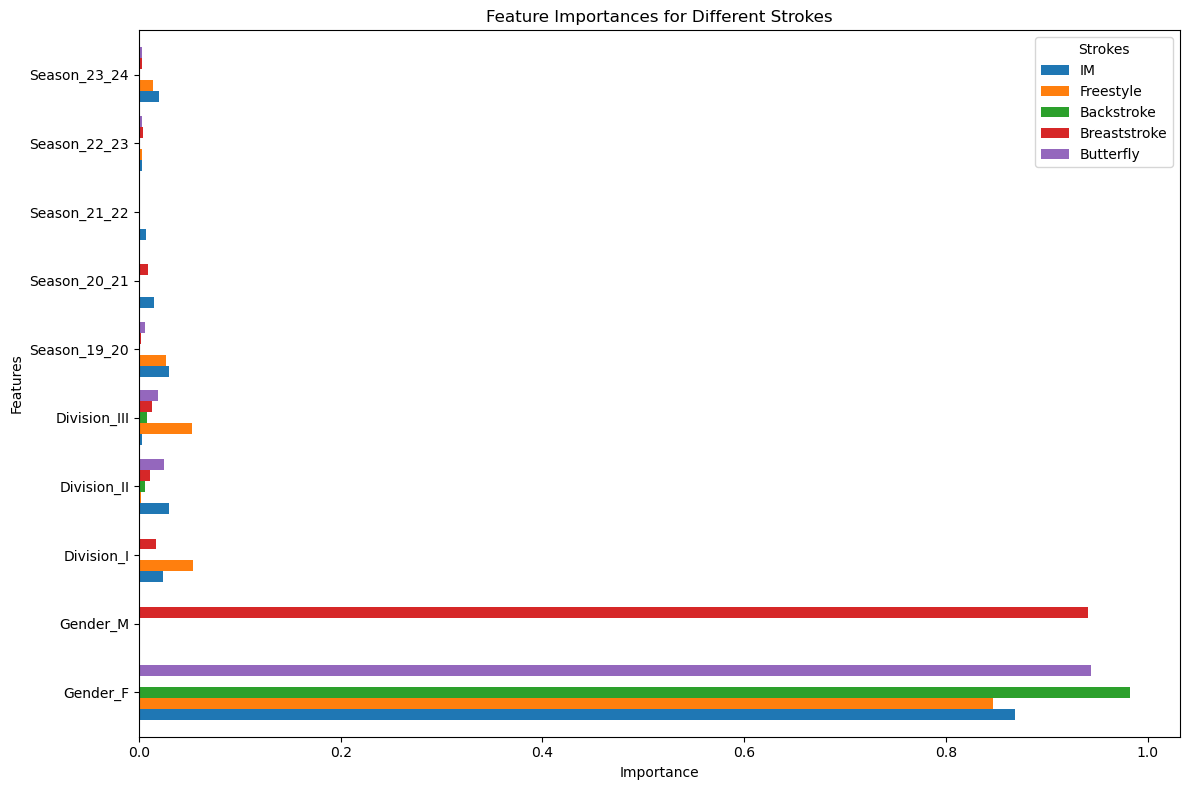

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
# Create a DataFrame for each stroke
df_im_importances = pd.DataFrame({'Features': X_ohe.columns, 'IM': im_importances})
df_fr_importances = pd.DataFrame({'Features': X_ohe.columns, 'Freestyle': freestyle_importances})
df_bk_importances = pd.DataFrame({'Features': X_ohe.columns, 'Backstroke': backstroke_importances})
df_bs_importances = pd.DataFrame({'Features': X_ohe.columns, 'Breaststroke': breaststroke_importances})
df_bf_importances = pd.DataFrame({'Features': X_ohe.columns, 'Butterfly': butterfly_importances})

# Merge them into a single DataFrame
df_importances = df_im_importances.merge(df_fr_importances, on='Features') \
                                  .merge(df_bk_importances, on='Features') \
                                  .merge(df_bs_importances, on='Features') \
                                  .merge(df_bf_importances, on='Features')

# Set the Features as the index
df_importances.set_index('Features', inplace=True)

# Plot the feature importances as a horizontal bar chart
df_importances.plot.barh(figsize=(12, 8), width=0.8)

plt.title('Feature Importances for Different Strokes')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.legend(title='Strokes', loc='best')
plt.tight_layout()
plt.show()
